In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.chdir('/Users/jamesl/Workspace/titanic')
sns.set()

# Reading the data
The first step will be to read in the data from data/raw/train.csv into a pandas dataframe. 

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
combine = [train, test]
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Looking for Missing Data and Taking a First Look
Next I will look for any missing data that we may have. Since most of the cabin information is missing, I may want to consider dropping that column. However, the letter infront of the cabin number indicates what deck someone was on in the titanic. I belive there may be a strong correlation between deck and survival and fare. However, I will explore that later. 

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
train['Name'].sample(n=20)

560                             Morrow, Mr. Thomas Rowan
444                    Johannesen-Bratthammer, Mr. Bernt
78                         Caldwell, Master. Alden Gates
259                          Parrish, Mrs. (Lutie Davis)
322                            Slayter, Miss. Hilda Mary
616                            Danbom, Mr. Ernst Gilbert
43              Laroche, Miss. Simonne Marie Anne Andree
684                    Brown, Mr. Thomas William Solomon
492                           Molson, Mr. Harry Markland
657                        Bourke, Mrs. John (Catherine)
378                                  Betros, Mr. Tannous
508                             Olsen, Mr. Henry Margido
543                                    Beane, Mr. Edward
383    Holverson, Mrs. Alexander Oskar (Mary Aline To...
374                           Palsson, Miss. Stina Viola
629                             O'Connell, Mr. Patrick D
607                          Daniel, Mr. Robert Williams
687                            

Every passenger seems to have a title attached to them. Next I will make a separate column containing their titles. Titles like mlle and mme are just french equivalents if ms. There are several titles such as Major or Captain that are rare so we can move all of those into their own rare title class. 

In [5]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Crosby, Capt. Edward Gifford",male,347082,B96 B98,S
freq,1,577,7,4,644


In [6]:
train[['Pclass', 'Survived']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [7]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [8]:
train[['SibSp', 'Survived']].groupby('SibSp').mean()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [9]:
train[['Parch', 'Survived']].groupby('Parch').mean()

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


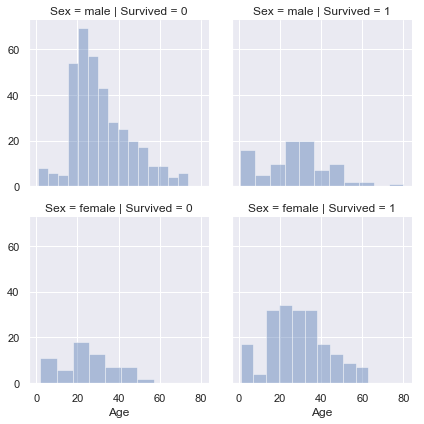

In [10]:
g = sns.FacetGrid(train, col='Survived', row='Sex')
g.map(sns.distplot, 'Age', kde=False)

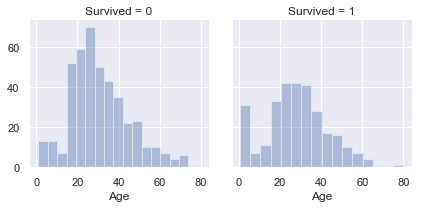

In [11]:
h = sns.FacetGrid(train, col='Survived')
h.map(sns.distplot, 'Age', kde=False)

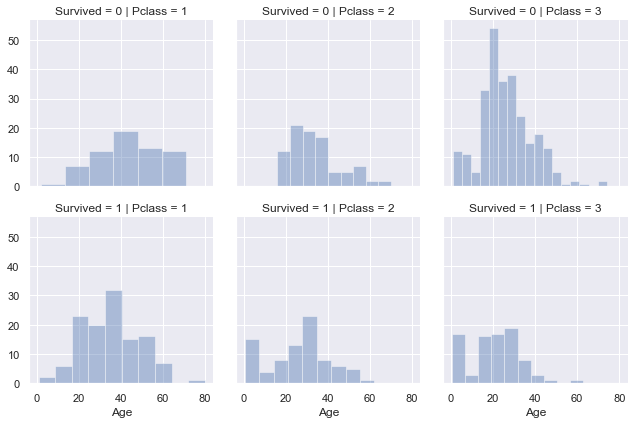

In [12]:
i = sns.FacetGrid(train, row='Survived', col='Pclass')
i.map(sns.distplot, 'Age', kde=False)

## Dropping and Adding Features
We will be dropping the cabin and the ticket features.

In [13]:
train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)
combine = [train, test]

In [14]:
for dataset in combine:
    dataset['Title'] = dataset['Name'].str.extract(' (\w+)\.', expand=False)

In [15]:
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [16]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Capt', 'Col', 'Don', 'Countess', 'Dr', \
                                                'Jonkheer', 'Lady', 'Major', 'Rev', 'Sir'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    
train[['Title', 'Survived']].groupby('Title').mean()

,Survived
Title,
Master,0.575000
Miss,0.704301
Mr,0.156673
Mrs,0.792000
Rare,0.347826


In [17]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [18]:
train = train.drop(['Name', 'PassengerId'], axis=1)
test = test.drop(['Name', 'PassengerId'], axis=1)
combine = [train, test]

In [19]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0})
    
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1
